# Integrantes
* Luis Fernando Botero Roba
* Gabriel Esteban Restrepo Giraldo
* Juan Camilo González Torres

In [ ]:
%pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
%cd "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"

/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
%ls

Testing/  Training/


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import os
import cv2

%matplotlib inline

# Cargar los datos

In [ ]:
def load_images_from_folder(folder, label, limit=None):
    """Carga imágenes desde una carpeta hasta un límite dado."""
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder):
        if limit and count >= limit:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Lee en escala de grises
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Ajusta el tamaño si es necesario
            images.append(img)
            labels.append(label)
            count += 1
    return images, labels

In [ ]:
# Directorios
train_path = "Training"
test_path = "Testing"

# 1. Cargar imágenes de "notumor" para determinar el límite
X_train, Y_train = load_images_from_folder(os.path.join(train_path, "notumor"), label=0)
X_test, Y_test = load_images_from_folder(os.path.join(test_path, "notumor"), label=0)

num_notumor_train = len(X_train)
num_notumor_test = len(X_test)

# 2. Cargar la mitad de glioma y la mitad de meningioma
glioma_train, y_glioma_train = load_images_from_folder(
    os.path.join(train_path, "glioma"), label=1, limit=num_notumor_train // 2
)
meningioma_train, y_meningioma_train = load_images_from_folder(
    os.path.join(train_path, "meningioma"), label=1, limit=num_notumor_train // 2
)

glioma_test, y_glioma_test = load_images_from_folder(
    os.path.join(test_path, "glioma"), label=1, limit=num_notumor_test // 2
)
meningioma_test, y_meningioma_test = load_images_from_folder(
    os.path.join(test_path, "meningioma"), label=1, limit=num_notumor_test // 2
)

# 3. Unir los conjuntos de datos
X_train += glioma_train + meningioma_train
Y_train += y_glioma_train + y_meningioma_train

X_test += glioma_test + meningioma_test
Y_test += y_glioma_test + y_meningioma_test

# Convertir listas a arrays de NumPy
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

X_train: (3189, 128, 128), Y_train: (3189,)
X_test: (809, 128, 128), Y_test: (809,)


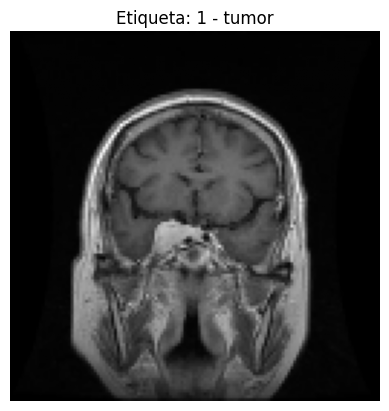

In [ ]:
# Diccionario de clases
classes = {0: "notumor", 1: "tumor"}  # 'tumor' representa glioma o meningioma

# Índice de la imagen a visualizar
index = 3000

# Mostrar la imagen
plt.imshow(X_train[index], cmap="gray")  # Asegurar escala de grises
plt.title(f"Etiqueta: {Y_train[index]} - {classes[Y_train[index]]}")
plt.axis("off")  # Ocultar ejes
plt.show()

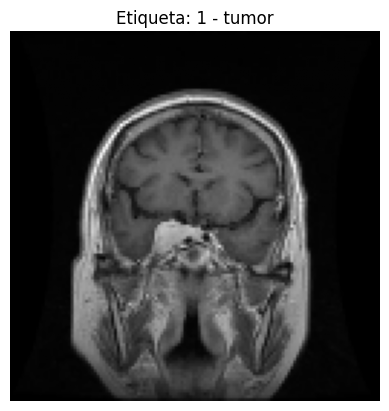

In [ ]:
# Normalizar los datos (convertir los valores de píxeles de 0-255 a 0-1)
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# Diccionario de clases
classes = {0: "notumor", 1: "tumor"}  # 'tumor' representa glioma o meningioma

# Índice de la imagen a visualizar
index = 3000

# Mostrar la imagen normalizada
plt.imshow(X_train_norm[index], cmap="gray")
plt.title(f"Etiqueta: {Y_train[index]} - {classes[Y_train[index]]}")
plt.axis("off")  # Ocultar ejes
plt.show()

# Funciones de apoyo

In [ ]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###

    return s

In [ ]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [ ]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [ ]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [ ]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


In [ ]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


In [ ]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)


    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [ ]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [ ]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # Reshape the input data to flatten the images
    X_train_flatten = X_train.reshape(X_train.shape[0], -1).T  # Reshape and transpose
    X_test_flatten = X_test.reshape(X_test.shape[0], -1).T  # Reshape and transpose

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train_flatten.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train_flatten, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test_flatten)
    Y_prediction_train = predict(w, b, X_train_flatten)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d


# Usar el modelo

In [ ]:
d = model(X_train_norm, Y_train, X_test_norm, Y_test, num_iterations = 2500, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.476518
Cost after iteration 200: 0.415884
Cost after iteration 300: 0.381396
Cost after iteration 400: 0.357843
Cost after iteration 500: 0.340136
Cost after iteration 600: 0.325995
Cost after iteration 700: 0.314229
Cost after iteration 800: 0.304150
Cost after iteration 900: 0.295325
Cost after iteration 1000: 0.287471
Cost after iteration 1100: 0.280390
Cost after iteration 1200: 0.273938
Cost after iteration 1300: 0.268010
Cost after iteration 1400: 0.262526
Cost after iteration 1500: 0.257421
Cost after iteration 1600: 0.252646
Cost after iteration 1700: 0.248159
Cost after iteration 1800: 0.243929
Cost after iteration 1900: 0.239925
Cost after iteration 2000: 0.236126
Cost after iteration 2100: 0.232512
Cost after iteration 2200: 0.229065
Cost after iteration 2300: 0.225770
Cost after iteration 2400: 0.222615
train accuracy: 94.41831295076827 %
test accuracy: 90.3584672435105 %


# Ejemplo de una mala clasificación

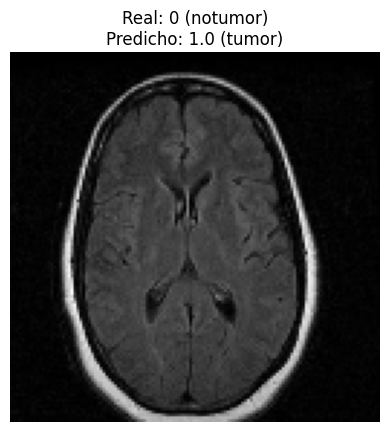

In [ ]:
# Suponiendo que d['Y_prediction_test'] contiene las predicciones de tu modelo
Y_pred = d['Y_prediction_test']  # Asegúrate de que tiene la misma forma que Y_test

# Encontrar índices donde la predicción es incorrecta
misclassified_indices = np.where(Y_pred[0] != Y_test)[0]

if len(misclassified_indices) > 0:
    index = misclassified_indices[0]  # Tomamos el primer caso mal clasificado

    plt.imshow(X_test[index], cmap="gray")
    plt.title(f"Real: {Y_test[index]} ({classes[Y_test[index]]})\nPredicho: {Y_pred[0, index]} ({classes[Y_pred[0, index]]})")
    plt.axis("off")
    plt.show()
else:
    print("No se encontraron imágenes mal clasificadas.")

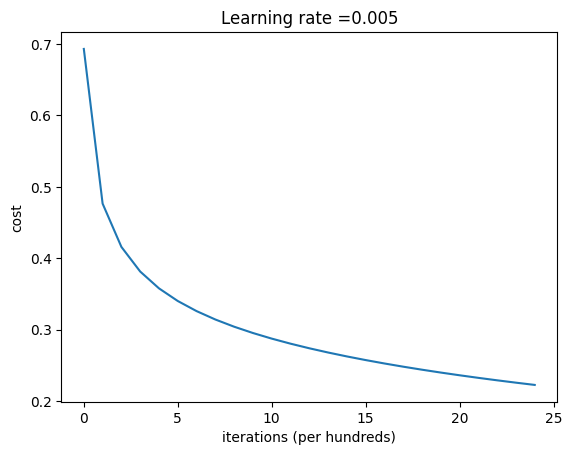

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

# Encontrando el Learning Rate óptimo

learning rate is: 0.01
train accuracy: 96.26842270304171 %
test accuracy: 91.84177997527811 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 90.43587331451866 %
test accuracy: 86.40296662546353 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 80.87174662903732 %
test accuracy: 76.88504326328801 %

-------------------------------------------------------



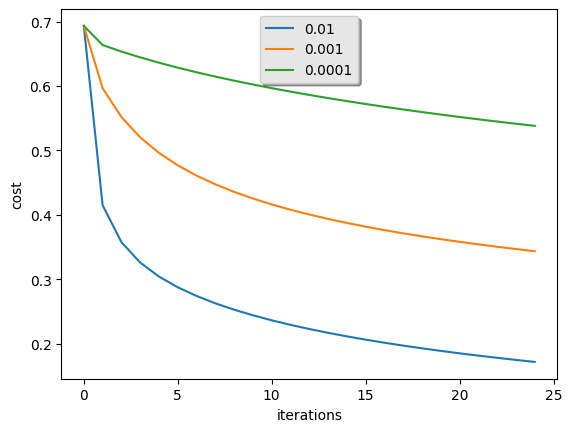

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(X_train_norm, Y_train, X_test_norm, Y_test, num_iterations = 2500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Usamos un learning rate de 0.05 para mejorar el modelo basado en lo observado

In [ ]:
d = model(X_train_norm, Y_train, X_test_norm, Y_test, num_iterations = 2500, learning_rate = 0.05, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.316284
Cost after iteration 200: 0.312382
Cost after iteration 300: 0.250710
Cost after iteration 400: 0.255711
Cost after iteration 500: 0.172256
Cost after iteration 600: 0.169123
Cost after iteration 700: 0.141200
Cost after iteration 800: 3.272300
Cost after iteration 900: 0.125048
Cost after iteration 1000: 0.112839
Cost after iteration 1100: 0.105015
Cost after iteration 1200: 0.098960
Cost after iteration 1300: 0.093920
Cost after iteration 1400: 0.089555
Cost after iteration 1500: 0.085678
Cost after iteration 1600: 0.082179
Cost after iteration 1700: 0.078988
Cost after iteration 1800: 0.076057
Cost after iteration 1900: 0.073350
Cost after iteration 2000: 0.070841
Cost after iteration 2100: 0.068505
Cost after iteration 2200: 0.066323
Cost after iteration 2300: 0.064279
Cost after iteration 2400: 0.062358
train accuracy: 99.24741298212606 %
test accuracy: 95.17923362175526 %


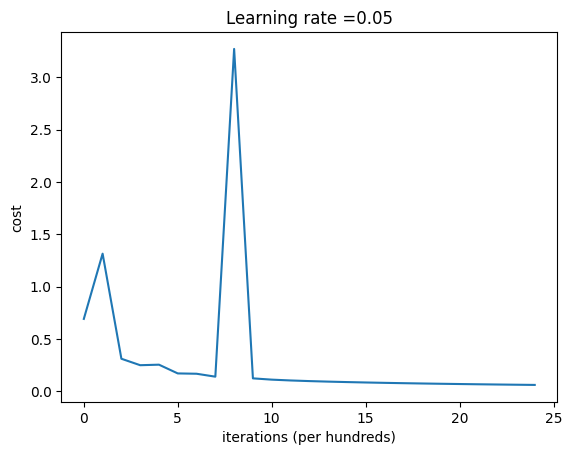

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

# Probar con una imagen propia

Saving prueba2.jpg to prueba2.jpg
Dimensiones originales: 800x678, Canales: 3


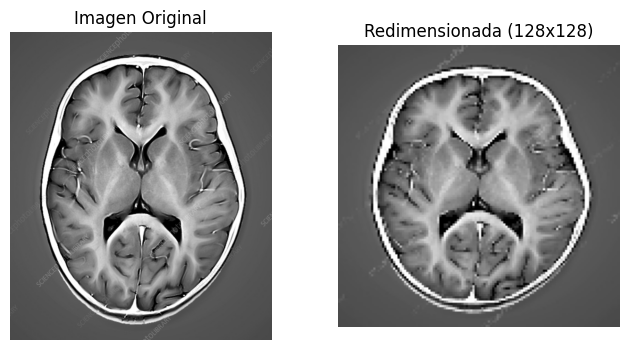

In [ ]:
from google.colab import files

# Subir una imagen desde tu computadora
uploaded = files.upload()

# Obtener el nombre del archivo cargado
image_path = list(uploaded.keys())[0]

# Leer la imagen
img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Asegurar lectura en color
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para mostrar correctamente en Matplotlib

# Mostrar dimensiones originales
height, width, channels = img.shape
print(f"Dimensiones originales: {height}x{width}, Canales: {channels}")

# Redimensionar la imagen al tamaño que usa el modelo (ejemplo: 64x64)
num_px = 128  # Asegúrate de que coincida con tu modelo
resized_img = cv2.resize(img, (num_px, num_px))

# Mostrar la imagen original y redimensionada
def plot_image(original, resized):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Imagen Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(resized)
    plt.title(f"Redimensionada ({num_px}x{num_px})")
    plt.axis("off")

    plt.show()

plot_image(img, resized_img)

In [ ]:
# Preparar la imagen para la predicción
my_image = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY) # Convert to grayscale
my_image = my_image.reshape((1, num_px * num_px)).T  # Asegurar formato adecuado

# Normalizar (importante para que coincida con los datos de entrenamiento)
my_image = my_image / 255.0

# Hacer la predicción con el modelo
my_predicted_image = predict(d["w"], d["b"], my_image)

# Mostrar el resultado
print(f"y = {np.squeeze(my_predicted_image)}, tu algoritmo predice: \"{classes[int(np.squeeze(my_predicted_image))]}\"")

y = 0.0, tu algoritmo predice: "notumor"
